# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [82]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [83]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX")

# set mapbox access token
px.set_mapbox_access_token(mapbox_token)

# Import Data

In [84]:
# Import the CSVs to Pandas DataFrames
file_path = Path("./Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("./Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [103]:
# define common dataframes
fig_housing_units = sfo_data['housing_units'].groupby('year').mean()

sales_rent = sfo_data[['sale_price_sqr_foot', 'gross_rent']].\
    groupby('year').mean()

sales_rent = sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby('year').mean()

sfo_df = sfo_data.groupby(['year', 'neighborhood']).mean()

most_expensive = sfo_data.groupby('neighborhood')\
                .mean()\
                .sort_values(ascending=False, by='sale_price_sqr_foot')

parallel_df = most_expensive.reset_index().round(decimals=2)



# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    min_units = min(fig_housing_units)
    max_units = max(fig_housing_units)
    std_units = fig_housing_units.std()
    
    housing_plot = plt.bar(
            fig_housing_units.index,
            fig_housing_units,
        )
    plt.ylim(
        (min_units - std_units),
        (max_units + std_units)
    )
    plt.xlim(
        sfo_data.index[0],
        sfo_data.index[-1]
    )
    plt.suptitle(
        'Housing Units in San Francisco from 2010 to 2016',
        weight='bold'
    )
    plt.xlabel('Year')
    plt.ylabel('Housing Units')
        
    return housing_plot

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    gross_rent_plot = plt.plot(
                sales_rent.index, 
                sales_rent['gross_rent']
            )
    plt.xlim(
        sales_rent.index[0],
        sales_rent.index[-1]
    )
    plt.suptitle(
        'Average Gross Rent in San Francisco',
        weight='bold'
    )
    plt.xlabel('Year')
    plt.ylabel('Gross Rent')
    
    return gross_rent_plot


def average_sales_price():
    """Average Sales Price Per Year."""   
    sales_plot = plt.plot(
        sales_rent.index,
        sales_rent['sale_price_sqr_foot']
    )
    plt.xlim(
        sales_rent.index[0],
        sales_rent.index[-1]
    )
    plt.suptitle(
        'Average Sale Price per Square Foot in San Francisco',
        weight='bold')
    plt.xlabel('Year')
    plt.ylabel('Avg. Sale Price')
    
    return sales_plot

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    price_neighborhood_plot = sfo_df['sale_price_sqr_foot'].hvplot(
        xlabel='year',
        ylabel='average sale per square foot',
        label=' ',
        groupby='neighborhood',
        height=300,
        width=450
    )
    
    return price_neighborhood_plot

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""    
    expensive_plot = most_expensive['sale_price_sqr_foot'].head(10).hvplot.bar(
        ylabel='average sale price per square foot',
        xlabel='neighborhood',
        label='top 10 most expensive neighborhoods',
        rot=40,
        height=400,
        width=650,
    )
    
    return expensive_plot

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    coordinates_plot = px.parallel_coordinates(
        most_expensive.head(10),
        color='sale_price_sqr_foot'
    )
    
    return coordinates_plot

def parallel_categories():
    """Parallel Categories Plot.""" 
    categories_plot = px.parallel_categories(
        parallel_df.head(10),
        color='sale_price_sqr_foot'
    )
    
    return categories_plot

def neighborhood_map():
    """Neighborhood Map"""
    
    neighborhood_combined = parallel_df.join(
        df_neighborhood_locations.set_index('Neighborhood'),
        how='inner',
        on='neighborhood'
    )
    
    neigborhood_plot = px.scatter_mapbox(
        neighborhood_combined,
        lat="Lat",
        lon="Lon",
        size="gross_rent",
        color="neighborhood",
        zoom=10,
        title='neighborhoods by gross rent',
        height=800,
        width=1000,
    )
    
    return neigborhood_plot

def neighborhood_map2():
    """Neighborhood Map"""
    
    neighborhood_combined = parallel_df.join(
        df_neighborhood_locations.set_index('Neighborhood'),
        how='inner',
        on='neighborhood'
    )
    
    neigborhood_plot = px.scatter_mapbox(
        neighborhood_combined,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="neighborhood",
        zoom=10,
        title='neighborhoods by average sale price per square foot',
        height=800,
        width=1000,
    )
    
    return neigborhood_plot


## Panel Dashboard
In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

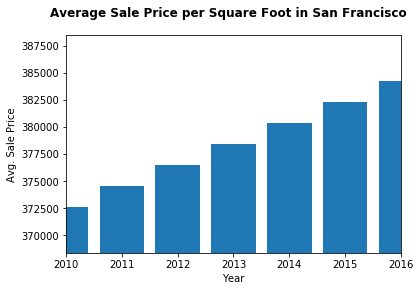

In [104]:
sf_market_plots = pn.Column(
    '## San Francisco housing market overview',
    housing_units_per_year(),
    average_gross_rent(),
    average_sales_price()
)

neighborhood_plots = pn.Column(
    '## San Francisco neighborhoods overview',
    average_price_by_neighborhood(),
    top_most_expensive_neighborhoods(),
    )

parallel_plots = pn.Column(
    '## Parallel plots',
    parallel_categories(),
    parallel_coordinates(),
)

neighborhood_maps = pn.Column(
    '## Neighborhood maps',
    neighborhood_map(),
    neighborhood_map2(),
)

dashboard = pn.Tabs(
    ('Housing market', sf_market_plots),
    ('Neighborhoods', neighborhood_plots),
    ('Parallels', parallel_plots),
    ('Neighborhood maps', neighborhood_maps),
)

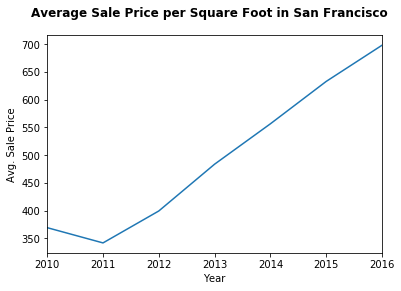

In [108]:
average_sales_price()

## Serve the Panel Dashboard

In [105]:
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(BarContainer)
        [2] Str(list)
        [3] Str(list)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)